In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt 
import time
from torch.utils import data
import warnings
from train import train_epoch, eval_epoch, test_epoch, Dataset
from mpl_toolkits.axes_grid1 import AxesGrid

warnings.filterwarnings("ignore")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2,3,4,5,6,7"
basis = torch.load("kernel_basis.pt")
train_direc = "/global/cscratch1/sd/roseyu/Eliza/TF-net/Data/data_64/sample_"
img_direc = "/global/cscratch1/sd/roseyu/Eliza/Img"

# Rot (+ UM + Mag)
- [ ] test for equivariance: check UM and Rot eq

In [2]:
class Ani_layer(nn.Module):
    def __init__(self, input_channels, output_channels, kernel_size, um_dim = 2, activation = False):
        super(Ani_layer, self).__init__()
        self.output_channels = output_channels
        self.input_channels = input_channels
        self.activation = activation
        self.kernel_size = kernel_size
        self.um_dim = um_dim
        self.radius = (kernel_size - 1)//2
        self.pad_size = (kernel_size - 1)//2
        self.num_weights = self.radius*4
        self.basis = basis[:self.num_weights, :, 15-self.radius:self.radius-15, 15-self.radius:self.radius-15]
        self.params = self.init_params()  
        
        self.bias_term = nn.Parameter(torch.ones(1, self.output_channels, 2, 1, 1)/100)
        
        initial_kernel = torch.einsum("abcd, cdefgh -> abcdefgh",  (self.params, self.basis))
        stds = torch.std(initial_kernel[initial_kernel != 0.0])
        
        #print(torch.std(initial_kernel, dim = (0,1,4,5,6,7)))
        
        self.scaler = np.sqrt(0.6/(np.sqrt(input_channels) * self.kernel_size**2 * stds))
        
        self.params = nn.Parameter(self.params * self.scaler)#.unsqueeze(0).unsqueeze(0).unsqueeze(-1))
        self.basis = self.basis * self.scaler#.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
        
        self.b = nn.Parameter(torch.tensor(0.01))
        
        self.initial_params = self.params.clone()
        self.initial_kernel = torch.einsum("abcd, cdefgh -> abefgh",  (self.params, self.basis)).clone()
        
    def init_params(self):
        return torch.randn((self.output_channels, self.input_channels, self.num_weights, 4))
    
    
    def get_kernel(self, params, basis):
        # Compute Kernel: Kernel shape (output_channels, input_channels, kernel_size, kernel_size, 2, 2) 
        kernel = torch.einsum("abcd, cdefgh -> abefgh",  (self.params, self.basis.to(device)))
        
        # Reshape
        kernel = kernel.transpose(-2, -3).transpose(-3, -4).transpose(-4, -5)       
        kernel = kernel.reshape(kernel.shape[0]*2,  kernel.shape[2], self.kernel_size, self.kernel_size, 2)
        kernel = kernel.transpose(-1, -2).transpose(-2, -3)
        kernel = kernel.reshape(kernel.shape[0], kernel.shape[1]*2, self.kernel_size, self.kernel_size)

        return kernel
    
    def unfold(self, xx):
        out = F.pad(xx, ((self.pad_size, self.pad_size)*2), mode='replicate')
        out = F.unfold(out, kernel_size = self.kernel_size)
        out = out.reshape(out.shape[0], self.input_channels * self.um_dim, self.kernel_size, self.kernel_size, out.shape[-1])
        out = out.reshape(out.shape[0], self.input_channels * self.um_dim, self.kernel_size, self.kernel_size, xx.shape[-2], xx.shape[-1])
        return out
    
    def subtract_mean(self, xx):
        out = xx.reshape(xx.shape[0], self.input_channels, self.um_dim, self.kernel_size, self.kernel_size, xx.shape[-2], xx.shape[-1])
        avgs = out.mean((1,3,4), keepdim=True)
        out -= avgs
        out = out.reshape(out.shape[0], self.input_channels * self.um_dim, self.kernel_size, self.kernel_size, xx.shape[-2], xx.shape[-1]).transpose(2,4).transpose(-1,-2)
        out = out.reshape(out.shape[0], self.input_channels * self.um_dim, xx.shape[-2]*self.kernel_size, xx.shape[-1], self.kernel_size)
        out = out.reshape(out.shape[0], self.input_channels * self.um_dim, xx.shape[-2]*self.kernel_size, xx.shape[-1]*self.kernel_size)
        return out, avgs.squeeze(3).squeeze(3)
    
    
    def add_mean(self, out, avgs):
        out += avgs
        out = out.reshape(out.shape[0], -1, out.shape[-2], out.shape[-1])
        return out
    
    def scale(self, xx):
        stds = xx.std((1, 2, 3), keepdim=True)
        out = xx / stds
        # out[out != out] = 0
        out = out.transpose(2, 4).transpose(-1, -2)
        out = out.reshape(out.shape[0], self.input_channels, xx.shape[-2] * self.kernel_size, xx.shape[-1],
                          self.kernel_size)
        out = out.reshape(out.shape[0], self.input_channels, xx.shape[-2] * self.kernel_size,
                          xx.shape[-1] * self.kernel_size)
        return out, stds.squeeze(2).squeeze(2)

    def scale_back(self, out, stds):
        out *= stds.unsqueeze(4)
        return out
    
    def forward(self, xx, add_mean = True):       
        kernel = self.get_kernel(self.params, self.basis)
        
        # Rot eq
        xx = self.unfold(xx)
        xx, avgs = self.subtract_mean(xx)
        
        # Mag eq
        stds = xx.std((1, 2, 3), keepdim=True)
        out = xx / stds

        # Conv2d
        out = F.conv2d(xx, kernel, stride = self.kernel_size) #, bias = self.bias_term
        out = out.reshape(out.shape[0], out.shape[1]//2, 2, out.shape[-2], out.shape[-1])
        out += self.bias_term
        
        # Activation Function
        if self.activation:
            # print("***")
            if self.activation == "sin":
                norm = torch.sqrt(out[:,:,0,:,:]**2 + out[:,:,1,:,:]**2).unsqueeze(2)
                out = out*torch.sin(norm)**2/norm

            elif self.activation == "relu":
                norm = torch.sqrt(out[:,:,0,:,:]**2 + out[:,:,1,:,:]**2).unsqueeze(2).repeat(1,1,2,1,1) 
                out = out/norm
                norm2 = norm - self.b
                out[norm2 <= 0.] = 0.    

            elif self.activation == "leakyrelu":
                norm = torch.sqrt(out[:,:,0,:,:]**2 + out[:,:,1,:,:]**2).unsqueeze(2).repeat(1,1,2,1,1) 
                out = out/norm
                norm2 = norm - self.b
                out[norm2 <= 0.] = out[norm2 <= 0.]*0.1

            elif self.activation == "squash":
                norm = torch.sqrt(out[:,:,0,:,:]**2 + out[:,:,1,:,:]**2).unsqueeze(2)
                out = out/norm*(norm**2/(norm**2+1))
        
        # Mag eq
        out = self.scale_back(out, stds)
        
        # Rot eq
        if add_mean:
            out = self.add_mean(out, avgs)
            
        return out
    
class rot_um_cnn(nn.Module):
    def __init__(self, input_channels, output_channels, hidden_dim, num_layers, kernel_size, activation = False):
        super(rot_um_cnn, self).__init__()
        layers = [Ani_layer(input_channels, hidden_dim, kernel_size, activation=activation)] + \
                 [Ani_layer(hidden_dim, hidden_dim, kernel_size, activation=activation) for i in range(num_layers - 2)] + \
                 [Ani_layer(hidden_dim, output_channels, kernel_size)]
        self.layers = nn.Sequential(*layers)

    def forward(self, xx):
        return self.layers(xx)

In [3]:
kernel_size = 3
hidden_dim = 128
num_layers = 2
learning_rate = 0.0001
input_length = 7
output_length = 1
batch_size = 2

train_indices = list(range(0, 10))
valid_indices = list(range(10, 15))


train_set = Dataset(train_indices, input_length, 40, output_length, train_direc, True)
valid_set = Dataset(valid_indices, input_length, 40, 6, train_direc, True)
train_loader = data.DataLoader(train_set, batch_size = batch_size, shuffle = True)
valid_loader = data.DataLoader(valid_set, batch_size = batch_size, shuffle = False)

In [4]:
print("Initializing...")
model = rot_um_cnn(activation = "relu", input_channels = input_length, hidden_dim = hidden_dim, num_layers = num_layers, output_channels = 1, kernel_size = kernel_size).to(device)#
print("Done")

optimizer = torch.optim.Adam(model.parameters(), learning_rate,betas=(0.9, 0.999), weight_decay=4e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size= 1, gamma=0.9)
loss_fun = torch.nn.MSELoss()

train_mse = []
valid_mse = []
test_mse = []
min_mse = 1
for i in range(30):
    start = time.time()
    scheduler.step()

    model.train()
    train_mse.append(train_epoch(train_loader, model, optimizer, loss_fun))
    model.eval()
    _, preds, trues = eval_epoch(train_loader, model, loss_fun)
    
    
    mse, preds, trues = eval_epoch(valid_loader, model, loss_fun)
    valid_mse.append(mse)

    if train_mse[-1] < min_mse:
        min_mse = train_mse[-1] 
        cnn_preds = preds
        cnn_trues = trues
        
        #torch.save(model, "model.pth")
    end = time.time()
    print(train_mse[-1], round((end-start)/60,5))#, valid_mse[-1]

Initializing...
Done
0.27101 0.02756
0.23538 0.00768
0.21374 0.00772
0.20143 0.00768
0.19311 0.00741
0.18845 0.00732
0.18471 0.0074
0.18183 0.00707
0.17974 0.00773
0.17818 0.00781
0.17705 0.00741
0.17603 0.03104
0.17519 0.01441
0.17445 0.00721
0.17384 0.00726
0.17323 0.02531
0.17277 0.01474
0.17239 0.00771
0.17195 0.01667
0.17164 0.00782
0.17133 0.00777
0.1711 0.00785
0.17086 0.02891
0.17067 0.00766
0.17048 0.00743
0.17032 0.01371
0.17018 0.01045
0.17005 0.03011
0.16994 0.00819
0.16984 0.01749


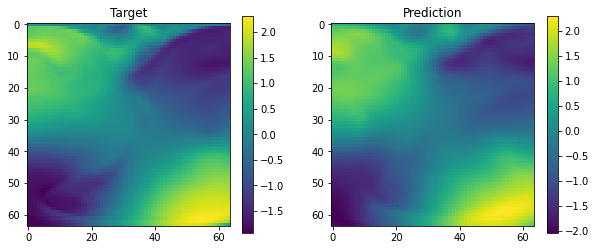

In [5]:
idx = 0
direc = 0
step = 0
fig=plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(cnn_trues[idx,step,direc])
plt.title("Target")
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(cnn_preds[idx,step,direc])
plt.title("Prediction")
plt.colorbar()
plt.show()
fig.savefig(img_direc + '/rot_um_target_pred', bbox_inches='tight')

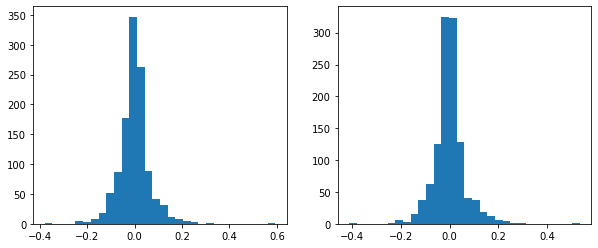

In [80]:
# Mag
fig=plt.figure(figsize=(10, 4))
initial_kernel = model.layers[0].initial_kernel.cpu().data.numpy()
trained_kernel = torch.einsum("abcd, cdefgh -> abefgh",  (model.layers[0].params, model.layers[0].basis.to(device))).cpu().data.numpy()

plt.subplot(1, 2, 1)
plt.hist(initial_kernel[:,0,:,:,0,0].flatten(), bins = 30)
plt.subplot(1, 2, 2)
plt.hist(trained_kernel[:,0,:,:,0,0].flatten(), bins = 30)
#plt.xlim(-0.5, 0.5)
plt.show()

In [81]:
# resnet = torch.load("/global/cscratch1/sd/roseyu/Eliza/Rot-UM/results.pt")

In [82]:
# plt.imshow(resnet["preds"][0,0,0])
# plt.colorbar()

In [83]:
# plt.imshow(resnet["trues"][0,0,0])
# plt.colorbar()

## Rotationaly symmetric test

In [6]:
import torchvision.transforms.functional as TF
from torchvision import transforms
PIL = transforms.ToPILImage()
TTen = transforms.ToTensor()
from PIL import Image


def normalize(tensor):
    return (tensor - torch.min(tensor))/(torch.max(tensor) - torch.min(tensor))

def rotate(img, degree):
    #img shape 2*128*128
    #2*2 2*1*128*128 -> 2*1*128*128
    theta = torch.tensor(degree/180*np.pi)
    rot_m = torch.tensor([[torch.cos(theta), -torch.sin(theta)], [torch.sin(theta), torch.cos(theta)]])
    img = torch.einsum("ab, bcde -> acde",(rot_m, img.unsqueeze(1))).squeeze(1)
    mmin = torch.min(img)
    mmax = torch.max(img)
    img = normalize(img).data.numpy()
    x = TTen(TF.rotate(Image.fromarray(np.uint8(img[0]*255)),degree, expand =  True))
    y = TTen(TF.rotate(Image.fromarray(np.uint8(img[1]*255)),degree, expand =  True))
    rot_img = torch.cat([x, y], dim = 0)
    rot_img[rot_img!=0] = normalize(rot_img[rot_img!=0])
    rot_img[rot_img!=0] = rot_img[rot_img!=0]*(mmax - mmin) + mmin
    return rot_img

train_direc = "/global/cscratch1/sd/roseyu/Eliza/TF-net/Data/data_128/sample_"
input_length = 2
output_length = 3
batch_size = 1
train_indices = list(range(0, 1))
train_set = Dataset(train_indices, input_length, 40, output_length, train_direc, True)
train_loader = data.DataLoader(train_set, batch_size = batch_size, shuffle = True)
for xx, yy in train_loader:
    break  

In [7]:
torch.manual_seed(10)
degree = 90

# model = Ani_layer(input_channels = 1, output_channels = 1, kernel_size = 7).to(device)
model = rot_um_cnn(input_channels = 2, output_channels = 1, hidden_dim = 128, num_layers = 4, kernel_size = 7, activation = "tanh").to(device)

rot_xx = torch.cat([rotate(xx[0,:2], degree).unsqueeze(0), rotate(xx[0,-2:], degree).unsqueeze(0)] , dim = 1)#rotate(xx[0,0], degree).unsqueeze(0)

rot_xx_out = model(rot_xx.to(device))
              
xx_out_rot = rotate((rot_xx_out[0]).cpu(), -degree)

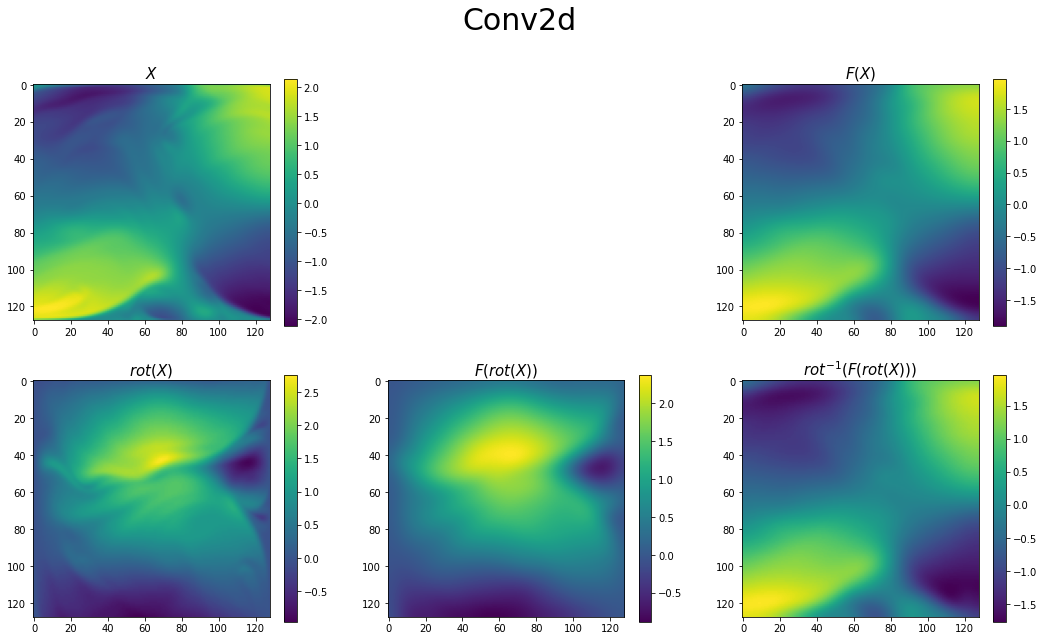

In [8]:
xx_out = model(xx.to(device))

rot_xx = torch.cat([rotate(xx[0,:2], degree).unsqueeze(0), rotate(xx[0,-2:], degree).unsqueeze(0)] , dim = 1)#rotate(xx[0,0], degree).unsqueeze(0)

rot_xx_out = model(rot_xx.to(device))
                
xx_out_rot = rotate((rot_xx_out[0]).cpu(), -degree)

direc = 0
fig=plt.figure(figsize=(18, 10))
plt.subplot(2, 3, 1)
plt.imshow(xx[0,direc].cpu().data.numpy())
plt.title(r"$X$", size = 15)
plt.colorbar()

plt.subplot(2, 3, 3)
plt.imshow(xx_out[0,direc].cpu().data.numpy())
plt.title(r"$F(X)$", size = 15)
plt.colorbar()

plt.subplot(2, 3, 4)
plt.imshow(rot_xx[0, direc].cpu().data.numpy())
plt.title(r"$rot(X)$", size = 15)
plt.colorbar()

plt.subplot(2, 3, 5)
plt.imshow(rot_xx_out[0,direc].cpu().data.numpy())
plt.title(r"$F(rot(X))$", size = 15)
plt.colorbar()

plt.subplot(2, 3, 6)
plt.imshow(xx_out_rot[direc].cpu().data.numpy())
plt.title(r"$rot^{-1}(F(rot(X)))$", size = 15)
plt.colorbar()

plt.suptitle("Conv2d", size = 30)

plt.show()
fig.savefig(img_direc + '/rot_um_conv2d_rot', bbox_inches='tight')

In [9]:
def rmse(y, y_hat):
    """Compute root mean squared error"""
    return torch.sqrt(torch.mean((y - y_hat).pow(2)))

def mse(y, y_hat):
    """Compute mean squared error"""
    return torch.mean((y - y_hat).pow(2))

xx_out_sample = xx_out[0,direc].cpu()
xx_out_rot_sample = xx_out_rot[direc].cpu()
print(rmse(xx_out_sample, xx_out_rot_sample))
print(mse(xx_out_sample, xx_out_rot_sample))

tensor(0.0447, grad_fn=<SqrtBackward>)
tensor(0.0020, grad_fn=<MeanBackward0>)


(array([1065., 1852., 1947., 2019., 2655., 1680., 1432., 1576., 1513.,
         645.]),
 array([-1.7767205 , -1.4024695 , -1.0282186 , -0.6539676 , -0.27971667,
         0.09453428,  0.46878523,  0.8430362 ,  1.2172872 ,  1.5915381 ,
         1.9657891 ], dtype=float32),
 <a list of 10 Patch objects>)

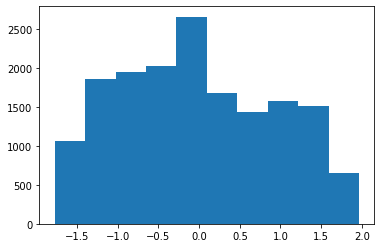

In [10]:
plt.hist(xx_out_rot[direc].cpu().data.numpy().flatten())

(array([ 557., 1574., 2069., 2082., 2656., 1974., 1498., 1592., 1643.,
         739.]),
 array([-1.9050674 , -1.5167472 , -1.1284269 , -0.7401067 , -0.35178646,
         0.03653377,  0.424854  ,  0.81317425,  1.2014945 ,  1.5898148 ,
         1.978135  ], dtype=float32),
 <a list of 10 Patch objects>)

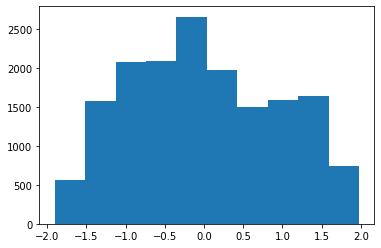

In [11]:
plt.hist(xx_out[0,direc].cpu().data.numpy().flatten())

## UM symmetric test

In [91]:
def sample_spherical(npoints, ndim=3):
    vec = np.random.randn(ndim, npoints)
    vec /= np.linalg.norm(vec, axis=0)
    return vec

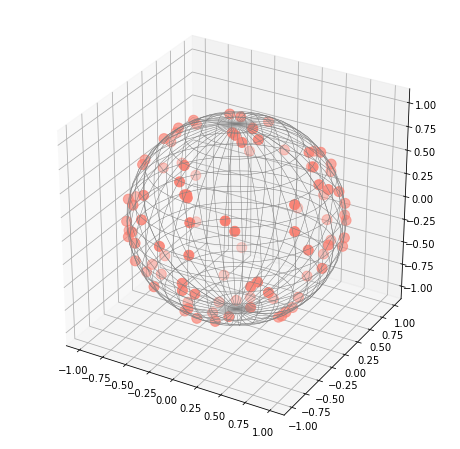

In [19]:
from mpl_toolkits.mplot3d import axes3d

phi = np.linspace(0, np.pi, 20)
theta = np.linspace(0, 2 * np.pi, 40)
x = np.outer(np.sin(theta), np.cos(phi))
y = np.outer(np.sin(theta), np.sin(phi))
z = np.outer(np.cos(theta), np.ones_like(phi))

xi, yi, zi = sample_spherical(100)

fig = plt.figure(figsize=plt.figaspect(1)*2) #Adjusts the aspect ratio and enlarges the figure (text does not enlarge)
ax = fig.gca(projection='3d')
ax.plot_wireframe(x, y, z, colors='gray', linewidths=0.5, rstride=1, cstride=1)
ax.scatter(xi, yi, zi, s=100, c='salmon', zorder=10)

plt.show()
# fig.savefig(img_direc + '/sample_spherical', bbox_inches='tight')

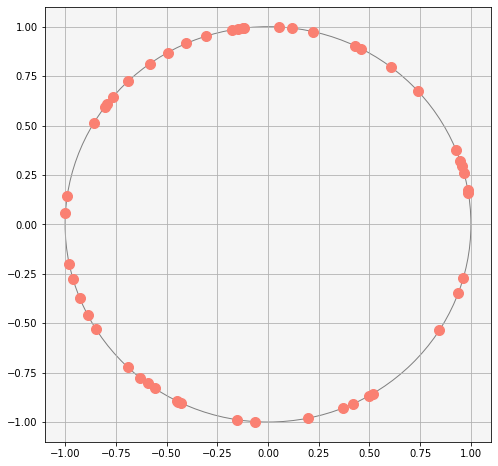

In [20]:
fig = plt.figure(figsize=plt.figaspect(1)*2)
ax = fig.add_subplot(1, 1, 1)

circ = plt.Circle((0, 0), radius=1, edgecolor='gray', facecolor='None')
ax.add_patch(circ)

xj, yj = sample_spherical(50, 2)
ax.scatter(xj, yj, s=100, c='salmon', zorder=10)

ax.set_facecolor('#f5f5f5')
plt.grid(b=None, which='major', axis='both')
plt.show()
# fig.savefig(img_direc + '/sample_cyclical', bbox_inches='tight')

In [12]:
def sample_within_spherical():
    t = 2 * np.pi * np.random.uniform()
    u = np.random.uniform() + np.random.uniform()
    r = 2 - u if u > 1 else u
    return [r * np.cos(t), r * np.sin(t)]

def sample_n_within_spherical(n=1):
    return np.array([sample_within_spherical() for i in range(n)]).transpose() 

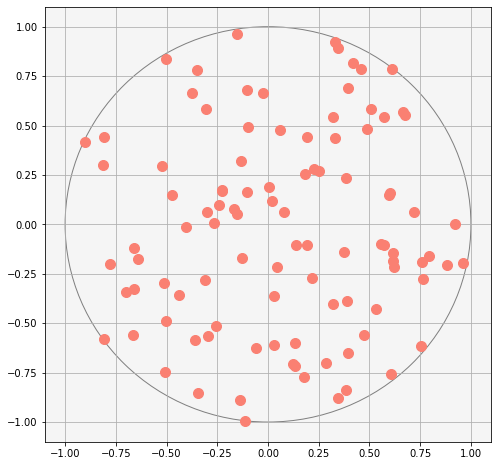

In [139]:
fig = plt.figure(figsize=plt.figaspect(1)*2)
ax = fig.add_subplot(1, 1, 1)

circ = plt.Circle((0, 0), radius=1, edgecolor='gray', facecolor='None')
ax.add_patch(circ)

xj, yj = sample_n_within_spherical(100)
ax.scatter(xj, yj, s=100, c='salmon', zorder=10)

ax.set_facecolor('#f5f5f5')
plt.grid(b=None, which='major', axis='both')
plt.show()
# fig.savefig(img_direc + '/sample_within_cyclical', bbox_inches='tight')

In [13]:
def normalize(tensor):
    return (tensor - torch.min(tensor))/(torch.max(tensor) - torch.min(tensor))

def uniform_motion(img, unit_vector):
    return img + torch.FloatTensor(unit_vector).repeat(img.shape[1]//2, img.shape[-1]**2).view(img.shape)

train_direc = "/global/cscratch1/sd/roseyu/Eliza/TF-net/Data/data_128/sample_"
input_length = 2
output_length = 3
batch_size = 1
train_indices = list(range(0, 1))
train_set = Dataset(train_indices, input_length, 40, output_length, train_direc, True)
train_loader = data.DataLoader(train_set, batch_size = batch_size, shuffle = True)
for xx, yy in train_loader:
    break  

In [14]:
torch.manual_seed(10)
um_vector = sample_n_within_spherical()

# model = Ani_layer(input_channels = 1, output_channels = 1, kernel_size = 7).to(device)
model = rot_um_cnn(input_channels = 2, output_channels = 1, hidden_dim = 128, num_layers = 4, kernel_size = 7, activation = "tanh").to(device)

um_xx = uniform_motion(xx, um_vector)

um_xx_out = model(um_xx.to(device))

xx_out_um = uniform_motion((um_xx_out).cpu(), -um_vector)

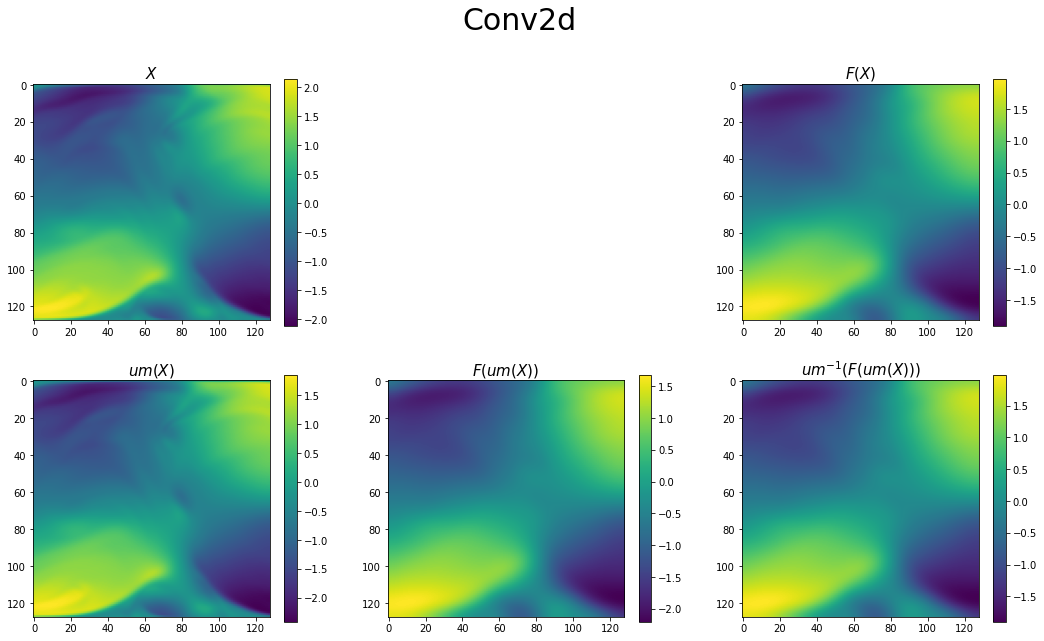

In [15]:
xx_out = model(xx.to(device))

um_xx = uniform_motion(xx, um_vector)

um_xx_out = model(um_xx.to(device))

xx_out_um = uniform_motion((um_xx_out).cpu(), -um_vector)

direc = 0
fig=plt.figure(figsize=(18, 10))
plt.subplot(2, 3, 1)
plt.imshow(xx[0,direc].cpu().data.numpy())
plt.title(r"$X$", size = 15)
plt.colorbar()

plt.subplot(2, 3, 3)
plt.imshow(xx_out[0,direc].cpu().data.numpy())
plt.title(r"$F(X)$", size = 15)
plt.colorbar()

plt.subplot(2, 3, 4)
plt.imshow(um_xx[0, direc].cpu().data.numpy())
plt.title(r"$um(X)$", size = 15)
plt.colorbar()

plt.subplot(2, 3, 5)
plt.imshow(um_xx_out[0,direc].cpu().data.numpy())
plt.title(r"$F(um(X))$", size = 15)
plt.colorbar()

plt.subplot(2, 3, 6)
plt.imshow(xx_out_um[0, direc].cpu().data.numpy())
plt.title(r"$um^{-1}(F(um(X)))$", size = 15)
plt.colorbar()

plt.suptitle("Conv2d", size = 30)

plt.show()
fig.savefig(img_direc + '/rot_um_conv2d_um', bbox_inches='tight')

In [16]:
def rmse(y, y_hat):
    """Compute root mean squared error"""
    return torch.sqrt(torch.mean((y - y_hat).pow(2)))

def mse(y, y_hat):
    """Compute root mean squared error"""
    return torch.mean((y - y_hat).pow(2))

xx_out_sample = xx_out[0,direc].cpu()
xx_out_um_sample = xx_out_um[0, direc].cpu()
print(rmse(xx_out_sample, xx_out_um_sample))
print(mse(xx_out_sample, xx_out_um_sample))

tensor(8.1649e-08, grad_fn=<SqrtBackward>)
tensor(6.6666e-15, grad_fn=<MeanBackward0>)


(array([1065., 1852., 1947., 2019., 2655., 1680., 1432., 1576., 1513.,
         645.]),
 array([-1.7767205 , -1.4024695 , -1.0282186 , -0.6539676 , -0.27971667,
         0.09453428,  0.46878523,  0.8430362 ,  1.2172872 ,  1.5915381 ,
         1.9657891 ], dtype=float32),
 <a list of 10 Patch objects>)

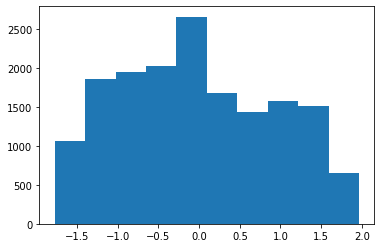

In [17]:
plt.hist(xx_out_rot[direc].cpu().data.numpy().flatten())

(array([ 557., 1574., 2069., 2082., 2656., 1974., 1498., 1592., 1643.,
         739.]),
 array([-1.9050674 , -1.5167472 , -1.1284269 , -0.7401067 , -0.35178646,
         0.03653377,  0.424854  ,  0.81317425,  1.2014945 ,  1.5898148 ,
         1.978135  ], dtype=float32),
 <a list of 10 Patch objects>)

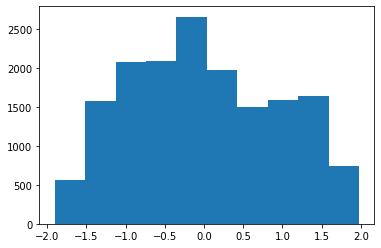

In [18]:
plt.hist(xx_out[0,direc].cpu().data.numpy().flatten())

## Magnitude symmetric test

In [5]:
def normalize(tensor):
    return (tensor - torch.min(tensor))/(torch.max(tensor) - torch.min(tensor))

def magnitude(img, scalar):
    return img * scalar

train_direc = "/global/cscratch1/sd/roseyu/Eliza/TF-net/Data/data_128/sample_"
input_length = 2
output_length = 3
batch_size = 1
train_indices = list(range(0, 1))
train_set = Dataset(train_indices, input_length, 40, output_length, train_direc, True)
train_loader = data.DataLoader(train_set, batch_size = batch_size, shuffle = True)
for xx, yy in train_loader:
    break  

In [7]:
torch.manual_seed(10)
high = 2
low = 0
mag_scalar = high - np.random.uniform(0, high - low) # ensure 0 is not choosen

# model = Ani_layer(input_channels = 1, output_channels = 1, kernel_size = 7).to(device)
model = rot_um_cnn(input_channels = 2, output_channels = 1, hidden_dim = 128, num_layers = 4, kernel_size = 7, activation = "tanh").to(device)

mag_xx = magnitude(xx, mag_scalar)

mag_xx_out = model(mag_xx.to(device))

xx_out_mag = magnitude((mag_xx_out).cpu(), 1 / mag_scalar)

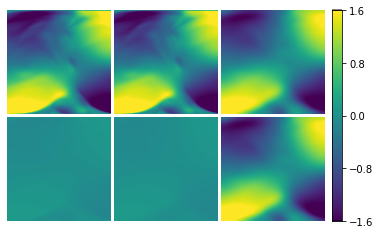

In [59]:
mag_data = [[xx[0,direc].cpu().data.numpy(), xx[0,direc].cpu().data.numpy(), xx_out[0,direc].cpu().data.numpy()],
           [mag_xx[0, direc].cpu().data.numpy(), mag_xx_out[0,direc].cpu().data.numpy(), xx_out_mag[0, direc].cpu().data.numpy()]]

fig = plt.figure(figsize=(6, 4))

grid = AxesGrid(fig, 111,
                nrows_ncols=(2, 3),
                axes_pad=0.05,
                cbar_mode='single',
                cbar_location='right',
                cbar_pad=0.1
                )

for row in range(2):
    for col in range(3):
        ax = grid[3 * row + col]
        ax.set_axis_off()
        im = ax.imshow(mag_data[row][col], vmin=-1.6, vmax=1.6)

cbar = ax.cax.colorbar(im)
cbar = grid.cbar_axes[0].colorbar(im)

plt.show()

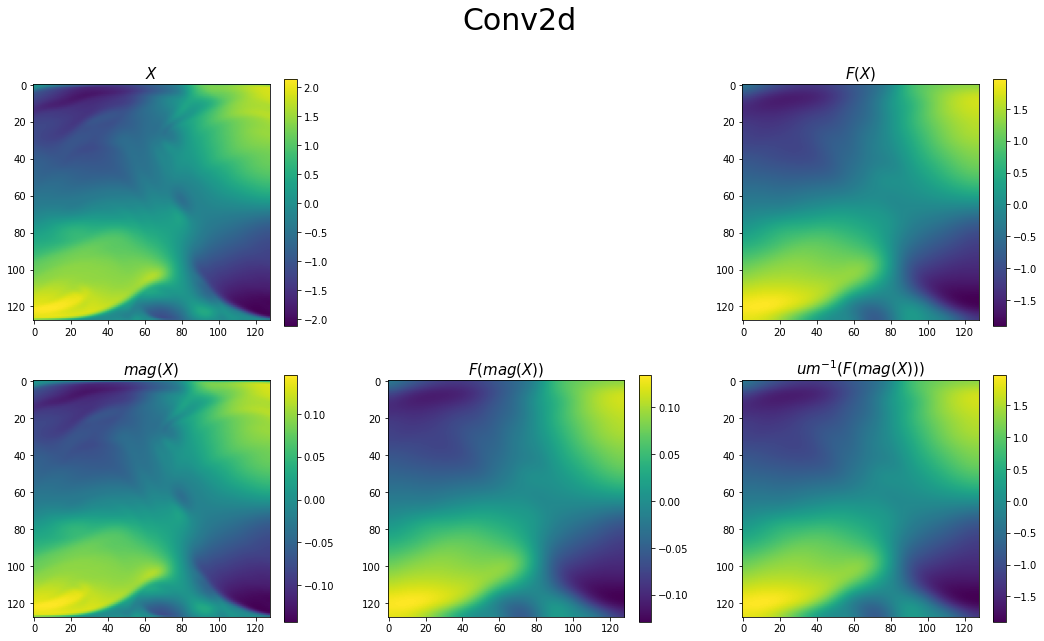

In [61]:
xx_out = model(xx.to(device))

mag_xx = magnitude(xx, mag_scalar)

mag_xx_out = model(mag_xx.to(device))

xx_out_mag = magnitude((mag_xx_out).cpu(), 1 / mag_scalar)

direc = 0
fig=plt.figure(figsize=(18, 10))
plt.subplot(2, 3, 1)
plt.imshow(xx[0,direc].cpu().data.numpy())
plt.title(r"$X$", size = 15)
plt.colorbar()

plt.subplot(2, 3, 3)
plt.imshow(xx_out[0,direc].cpu().data.numpy())
plt.title(r"$F(X)$", size = 15)
plt.colorbar()

plt.subplot(2, 3, 4)
plt.imshow(mag_xx[0, direc].cpu().data.numpy())
plt.title(r"$mag(X)$", size = 15)
plt.colorbar()

plt.subplot(2, 3, 5)
plt.imshow(mag_xx_out[0,direc].cpu().data.numpy())
plt.title(r"$F(mag(X))$", size = 15)
plt.colorbar()

plt.subplot(2, 3, 6)
plt.imshow(xx_out_mag[0, direc].cpu().data.numpy())
plt.title(r"$um^{-1}(F(mag(X)))$", size = 15)
plt.colorbar()

plt.suptitle("Conv2d", size = 30)

plt.show()
fig.savefig(img_direc + '/rot_mag_conv2d_mag', bbox_inches='tight')

In [12]:
def rmse(y, y_hat):
    """Compute root mean squared error"""
    return torch.sqrt(torch.mean((y - y_hat).pow(2)))

def mse(y, y_hat):
    """Compute root mean squared error"""
    return torch.mean((y - y_hat).pow(2))

xx_out_sample = xx_out[0,direc].cpu()
xx_out_mag_sample = xx_out_mag[0, direc].cpu()
print(rmse(xx_out_sample, xx_out_mag_sample))
print(mse(xx_out_sample, xx_out_mag_sample))

tensor(0.0018, grad_fn=<SqrtBackward>)
tensor(3.2294e-06, grad_fn=<MeanBackward0>)


## Ani_layer2

In [49]:
# class Ani_layer2(nn.Module):
#     def __init__(self, input_channels, output_channels, kernel_size, activation = False):
#         super(Ani_layer2, self).__init__()
#         self.output_channels = output_channels
#         self.input_channels = input_channels
#         self.activation = activation
#         self.kernel_size = kernel_size
#         self.radius = (kernel_size - 1)//2
#         self.pad_size = (kernel_size - 1)//2
#         self.basis = basis[:self.radius, :, 15-self.radius:self.radius-15, 15-self.radius:self.radius-15]
        
#         self.params = self.init_params()
#         scaler = np.sqrt(0.6/(np.sqrt(input_channels)*self.kernel_size**2*torch.std(torch.einsum("abcd, cdefgh -> abefgh",  (self.params, self.basis)))))
#         self.params = nn.Parameter(self.params*scaler)
#         self.basis = self.basis*scaler
#         #print(self.params[0,0,0,0])
#     def init_params(self):
#         return torch.randn((self.output_channels, self.input_channels, self.radius, 4))
    
#     def input_reshape(self, xx):
#         out= F.unfold(xx, kernel_size = self.kernel_size).transpose(1,2)
        
#         out = out.reshape(xx.shape[0], xx.shape[-2]-2*self.pad_size, xx.shape[-1]-2*self.pad_size, -1)
        
#         out = out.reshape(xx.shape[0], xx.shape[-2]-2*self.pad_size, xx.shape[-1]-2*self.pad_size, self.input_channels*2, self.kernel_size, self.kernel_size)
        
#         out = out.reshape(xx.shape[0], xx.shape[-2]-2*self.pad_size, xx.shape[-1]-2*self.pad_size, self.input_channels, 2, self.kernel_size, self.kernel_size)
        
#         out = out.transpose(-2,-3).transpose(-1,-2).unsqueeze(-1)
       
#         return out
    
#     def forward(self, xx):
#         #kernel shape: (output_channels, input_channels, kernel_size, kernel_size, 2, 2)
        
#         kernel = torch.einsum("abcd, cdefgh -> abefgh",  (self.params, self.basis.to(device)))
        
#         # Padding
#         inp_xx = F.pad(xx, (self.pad_size, self.pad_size, self.pad_size, self.pad_size))
        
#         # Unfold & Reshape
#         inp_xx  = self.input_reshape(inp_xx)
     
#         # Output Tensor
        
#         #print(inp_xx.shape, kernel.shape)
#         output = torch.einsum("abcdefgh, xdefyg-> axbcyh", (inp_xx, kernel)).squeeze(-1).transpose(-1,-2).transpose(-2,-3)
#         #print(output.shape)
#         if self.activation:
#             norm = torch.sqrt(output[:,:,0,:,:]**2 + output[:,:,1,:,:]**2).unsqueeze(-1)
#             output = output*torch.tanh(norm)/norm
#             output = output.reshape(xx.shape[0], self.output_channels*2, xx.shape[-2], xx.shape[-1])
#         else:
#             output = output.reshape(xx.shape[0], self.output_channels*2, xx.shape[-2], xx.shape[-1])
        
#         return output

In [50]:
# torch.manual_seed(10)
# degree = 90

# model = Ani_layer2(input_channels = 1, output_channels = 1, kernel_size = 7).to(device)

# print(xx.shape)
# xx_out = model(xx.reshape(xx.shape[0], -1, xx.shape[-2], xx.shape[-1]).to(device))

# rot_xx = rotate(xx[0,0], degree)

# rot_xx_out = model(rot_xx.unsqueeze(0).to(device))
                
# xx_out_rot = rotate((rot_xx_out[0]).cpu(), -degree)

# fig=plt.figure(figsize=(18, 10))
# plt.subplot(2, 3, 1)
# plt.imshow(xx[0,0,1].cpu().data.numpy())
# plt.title(r"$X$", size = 15)
# plt.colorbar()

# plt.subplot(2, 3, 3)
# plt.imshow(xx_out[0,1].cpu().data.numpy())
# plt.title(r"$F(X)$", size = 15
# plt.colorbar()

# plt.subplot(2, 3, 4)
# plt.imshow(rot_xx[1].cpu().data.numpy())
# plt.title(r"$rot(X)$", size = 15)
# plt.colorbar()

# plt.subplot(2, 3, 5)
# plt.imshow(rot_xx_out[0,1].cpu().data.numpy())
# plt.title(r"$F(rot(X))$", size = 15)
# plt.colorbar()

# plt.subplot(2, 3, 6)
# plt.imshow(xx_out_rot[1].cpu().data.numpy())
# plt.title(r"$rot^{-1}(F(rot(X)))$", size = 15)
# plt.colorbar()
# plt.suptitle("Einsum", size = 30)

# plt.show()


### Basic Matrices

In [2]:
def rotMat(theta, inverse = False):
    theta = torch.tensor(theta)
    sin = torch.sin(theta)
    cos = torch.cos(theta)
    mat = torch.cat([cos.unsqueeze(1), sin.unsqueeze(1)*(-1), sin.unsqueeze(1), cos.unsqueeze(1)], dim = 1).reshape(-1,2,2) 
    if inverse:
        return mat.inverse().float()
    return mat.float()


max_radius = 16
min_radius = 0.5
step_radius = 0.25
num_radius = (max_radius - min_radius-1)/step_radius
center_x = max_radius-1
center_y = max_radius-1
basis = torch.zeros(int(num_radius), 4, 31, 31, 2, 2)

Ms = [torch.tensor([[1.,0.],[0.,0.]]), torch.tensor([[0.,1.],[0.,0.]]), torch.tensor([[0.,0.],[1.,0.]]), torch.tensor([[0.,0.],[0.,1.]])]
for rad_id in range(1, int(num_radius)):
    rad = (rad_id-1) * step_radius + min_radius 
    for i in range(len(Ms)):
        for rr in np.linspace(rad - 0.25, rad + 0.25, 6):
            theta = np.linspace(0, np.pi*2, int(500*rr//2))
            x = (np.round(np.cos(theta)*rad)).astype("int32") 
            y = (np.round(np.sin(theta)*rad)).astype("int32")
            id_x = center_x - y 
            id_y = center_y + x
            out = torch.einsum("zac, zcd -> zad", (torch.einsum("zab, bc->zac", (rotMat(theta), Ms[i])), rotMat(theta, inverse = True)))
            for j in range(len(x)):
                basis[rad_id, i, id_x[j], id_y[j]] += out[j] 
                
for i in range(len(Ms)):
    basis[0, i, center_x, center_y] = 500*Ms[i]

In [3]:
basis.shape

torch.Size([58, 4, 31, 31, 2, 2])

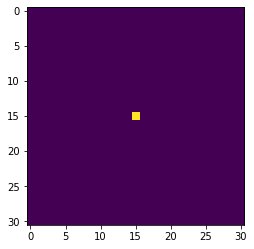

In [4]:
plt.imshow(basis[1,0,:,:,0,0])

In [5]:
basis[1,3,15,15]

tensor([[3.7050e+02, 2.5705e-06],
        [2.5705e-06, 3.7650e+02]])

In [6]:
basis[1,0,15,15]

tensor([[ 3.7650e+02, -2.5705e-06],
        [-2.5705e-06,  3.7050e+02]])

In [7]:
torch.save(basis/500, "kernel_basis.pt")

(-2, 2)

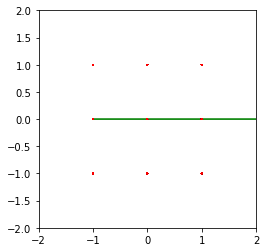

In [8]:
import matplotlib.pyplot as plt
import numpy as np

X, Y = np.meshgrid(np.arange(-1, 2, 1), np.arange(1, -2, -1))

x_shape = X.shape

U = basis[0,0,:,:,0,0]
V = basis[0,0,:,:,1,0]

U2 = basis[0,0,:,:,0,1]
V2 = basis[0,0,:,:,1,1]

fig, ax = plt.subplots()
q = ax.quiver(X, Y, U, V, units='xy' ,scale=2, color='green')
q = ax.quiver(X, Y, U2, V2, units='xy' ,scale=2, color='red')
ax.set_aspect('equal')

plt.xlim(-2,2)
plt.ylim(-2,2)

(-2, 2)

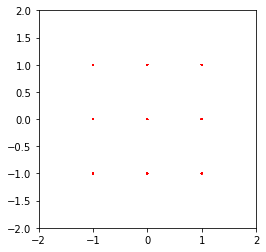

In [9]:
import matplotlib.pyplot as plt
import numpy as np

X, Y = np.meshgrid(np.arange(-1, 2, 1), np.arange(1, -2, -1))

x_shape = X.shape

U = basis[0,0,:,:,0,1]
V = basis[0,0,:,:,1,1]

def rotate_vec(img, degree):
    #img shape 2*128*128
    img = torch.tensor(img).float()
    #2*2 2*1*128*128 -> 2*1*128*128
    
    theta = torch.tensor(degree/180*np.pi)
    rot_m = torch.tensor([[torch.cos(theta), -torch.sin(theta)], [torch.sin(theta), torch.cos(theta)]])
    img = torch.einsum("ab, bcde -> acde",(rot_m, img.unsqueeze(1))).squeeze(1)
    return img

stack = np.stack([U,V])
rot_U = rotate_vec(stack, 90)[0]
rot_V = rotate_vec(stack, 90)[1]


fig, ax = plt.subplots()
q = ax.quiver(X, Y, U, V, units='xy' ,scale=2, color='red')

ax.set_aspect('equal')

plt.xlim(-2,2)
plt.ylim(-2,2)

In [10]:
torch.save(basis, "kernel_basis.pt")
print("Basic Matrices Saved")

Basic Matrices Saved


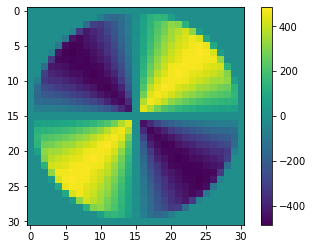

In [11]:
basis = torch.load("kernel_basis.pt")
basis = torch.sum(basis, dim = 0).data.numpy()
plt.imshow(basis[0,:,:,0,1])
plt.colorbar()

In [130]:
def rotMat(theta, inverse = False):
    theta = torch.tensor(theta)
    sin = torch.sin(theta)
    cos = torch.cos(theta)
    mat = torch.cat([cos.unsqueeze(1), sin.unsqueeze(1)*(-1), sin.unsqueeze(1), cos.unsqueeze(1)], dim = 1).reshape(-1,2,2) 
    if inverse:
        return mat.inverse().float()
    return mat.float()

basis = torch.zeros(2, 4, 3, 3, 2, 2)
Ms = [torch.tensor([[1.,0.],[0.,0.]]), torch.tensor([[0.,1.],[0.,0.]]), torch.tensor([[0.,0.],[1.,0.]]), torch.tensor([[0.,0.],[0.,1.]])]
for rad in range(1, 2):
    for i in range(len(Ms)):
        for rr in np.linspace(rad - 0.25, rad + 0.25, 6):
            theta = np.linspace(0, np.pi*2, int(500*rr//2))
            x = (np.round(np.cos(theta)*rad)).astype("int32") + 1
            y = (np.round(np.sin(theta)*rad)).astype("int32") + 1
            out = torch.einsum("zac, zcd -> zad", (torch.einsum("zab, bc->zac", (rotMat(theta), Ms[i])), rotMat(theta, inverse = True)))
            for j in range(len(x)):
                basis[rad-1, i, x[j], y[j]] += out[j]     


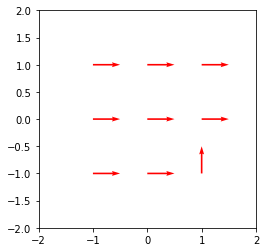

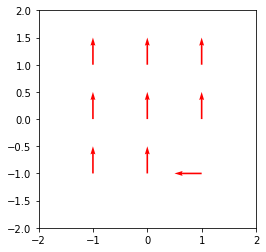

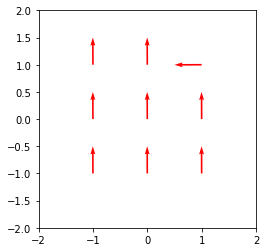

In [131]:
def rotate(img, degree):
    #img shape 2*128*128
    #2*2 2*1*128*128 -> 2*1*128*128
    theta = torch.tensor(degree/180*np.pi)
    rot_m = torch.tensor([[torch.cos(theta), -torch.sin(theta)], [torch.sin(theta), torch.cos(theta)]])
    img = torch.einsum("ab, bcde -> acde",(rot_m, img.unsqueeze(1))).squeeze(1)
    mmin = torch.min(img)
    mmax = torch.max(img)
    img = normalize(img).data.numpy()
    x = TTen(TF.rotate(Image.fromarray(np.uint8(img[0]*255)),degree, expand =  True))
    y = TTen(TF.rotate(Image.fromarray(np.uint8(img[1]*255)),degree, expand =  True))
    rot_img = torch.cat([x, y], dim = 0)
    rot_img[rot_img!=0] = normalize(rot_img[rot_img!=0])
    rot_img[rot_img!=0] = rot_img[rot_img!=0]*(mmax - mmin) + mmin
    return rot_img

def rotate_img(img, degree):
    img = torch.tensor(img).float()
    mmin = torch.min(img)
    mmax = torch.max(img)
    img = normalize(img).data.numpy()
    x = TTen(TF.rotate(Image.fromarray(np.uint8(img[0]*255)),degree,expand =  True))
    y = TTen(TF.rotate(Image.fromarray(np.uint8(img[1]*255)),degree,expand =  True))
    rot_img = torch.cat([x, y], dim = 0)
    #print(np.max(img), np.min(img), torch.max(rot_img), torch.min(rot_img))
    rot_img = rot_img*(mmax - mmin) + mmin
    return rot_img.cpu().data.numpy()

def rotate_vec(img, degree):
    #img shape 2*128*128
    img = torch.tensor(img).float()
    #2*2 2*1*128*128 -> 2*1*128*128
    
    theta = torch.tensor(degree/180*np.pi)
    rot_m = torch.tensor([[torch.cos(theta), -torch.sin(theta)], [torch.sin(theta), torch.cos(theta)]])
    img = torch.einsum("ab, bcde -> acde",(rot_m, img.unsqueeze(1))).squeeze(1)
    return img

import matplotlib.pyplot as plt
import numpy as np

X, Y = np.meshgrid(np.arange(-1, 2, 1), np.arange(1, -2, -1))

x_shape = X.shape

U = np.ones(x_shape)
V = np.zeros(x_shape)

#for i in range(x_shape[0]):
 #   for j in range(x_shape[1]):
       # U[i,j] = 1-i/10
        #V[i,j] = np.sin(i/20*7)

U[2,2] = 0
V[2,2] = 1


stack = np.stack([U,V])
rot_U = rotate_vec(stack, 90)[0]
rot_V = rotate_vec(stack, 90)[1]


fig, ax = plt.subplots()
q = ax.quiver(X, Y, U, V, units='xy' ,scale=2, color='red')

ax.set_aspect('equal')

plt.xlim(-2,2)
plt.ylim(-2,2)


fig, ax = plt.subplots()
q = ax.quiver(X, Y, rot_U, rot_V, units='xy' ,scale=2, color='red')
ax.set_aspect('equal')

plt.xlim(-2,2)
plt.ylim(-2,2)
plt.show()

stack = np.stack([rot_U,rot_V])
rot_U2 = rotate_img(stack, 90)[0]
rot_V2 = rotate_img(stack, 90)[1]
fig, ax = plt.subplots()
q = ax.quiver(X, Y, rot_U2, rot_V2, units='xy' ,scale=2, color='red')
ax.set_aspect('equal')

plt.xlim(-2,2)
plt.ylim(-2,2)
plt.show()

In [132]:
class CNN(nn.Module):
    def __init__(self, input_channels, output_channels, hidden_dim,  kernel_size, num_layers, activation = False, bias = True):
        super(CNN, self).__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(input_channels*2, hidden_dim, kernel_size = kernel_size, padding = (kernel_size-1)//2, bias = bias),
            #nn.BatchNorm2d(hidden_dim),
            nn.ReLU(),
            nn.Conv2d(hidden_dim, hidden_dim, kernel_size = kernel_size, padding = (kernel_size-1)//2, bias = bias),
            #nn.BatchNorm2d(hidden_dim),
            nn.ReLU(),
            nn.Conv2d(hidden_dim, hidden_dim, kernel_size = kernel_size, padding = (kernel_size-1)//2, bias = bias),
            #nn.BatchNorm2d(hidden_dim),
            nn.ReLU(),
            nn.Conv2d(hidden_dim, hidden_dim, kernel_size = kernel_size, padding = (kernel_size-1)//2, bias = bias),
            #nn.BatchNorm2d(hidden_dim),
            nn.ReLU(),
            nn.Conv2d(hidden_dim, output_channels*2, kernel_size = kernel_size, padding = (kernel_size-1)//2, bias = bias)
        )
        self.initial_params = self.layer[0].weight.clone()
         
        for m in self.modules():
            if isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
                
    def forward(self, xx):
        xx = xx.reshape(xx.shape[0], -1, xx.shape[-2], xx.shape[-1])
        out = self.layer(xx)
        out = out.reshape(out.shape[0], out.shape[1]//2, 2, xx.shape[-2], xx.shape[-1])
        return out

# Compare Train/Test setting

In [2]:
idx = '1'

test_mse []


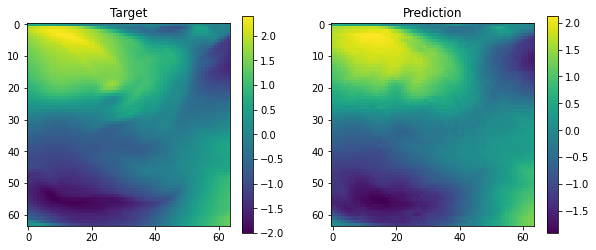

In [3]:
rot_results = torch.load("Rot-UM-CNN"+idx+".pt")
print('test_mse', rot_results['test_mse'])

fig=plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(rot_results['trues'][0][0][0])
plt.title("Target")
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(rot_results['preds'][0][0][0])
plt.title("Prediction")
plt.colorbar()
plt.show()
fig.savefig(img_direc + '/test_on_original', bbox_inches='tight')

test_mse []


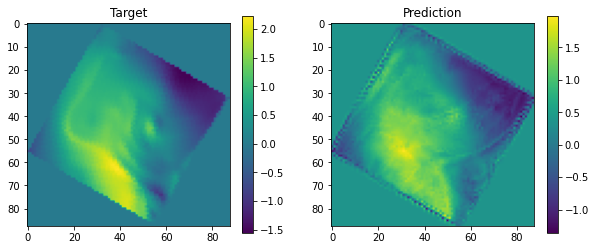

In [4]:
rot_results = torch.load("Rot-UM-CNN-Rot"+idx+".pt")
print('test_mse', rot_results['test_mse'])

fig=plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(rot_results['trues'][0][0][0][0])
plt.title("Target")
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(rot_results['preds'][0][0][0][0])
plt.title("Prediction")
plt.colorbar()
plt.show()
fig.savefig(img_direc + '/test_on_rot', bbox_inches='tight')

test_mse []


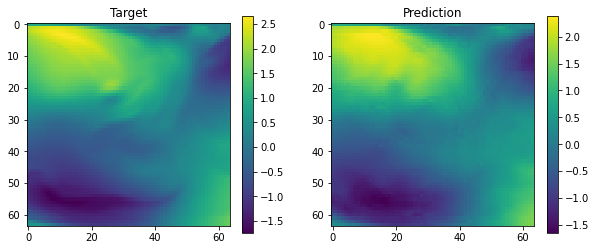

In [5]:
rot_results = torch.load("Rot-UM-CNN-UM"+idx+".pt")
print('test_mse', rot_results['test_mse'])

fig=plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(rot_results['trues'][0][0][0])
plt.title("Target")
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(rot_results['preds'][0][0][0])
plt.title("Prediction")
plt.colorbar()
plt.show()
fig.savefig(img_direc + '/test_on_um', bbox_inches='tight')

test_mse []


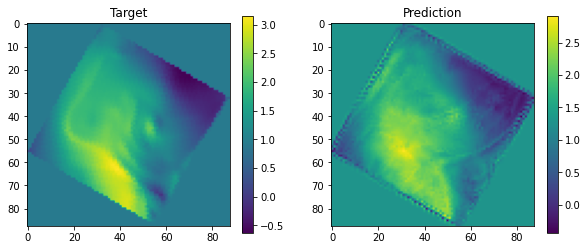

In [6]:
rot_results = torch.load("Rot-UM-CNN-Rot-UM"+idx+".pt")
print('test_mse', rot_results['test_mse'])

fig=plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(rot_results['trues'][0][0][0][0])
plt.title("Target")
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(rot_results['preds'][0][0][0][0])
plt.title("Prediction")
plt.colorbar()
plt.show()
fig.savefig(img_direc + '/test_on_rot_um', bbox_inches='tight')

In [8]:
# rot_results = torch.load("Rot-UM-CNN-Org-Rot-UM"+idx+".pt")
# print('test_mse', rot_results['test_mse'])

# fig=plt.figure(figsize=(10, 4))
# plt.subplot(1, 2, 1)
# plt.imshow(rot_results['trues'][0][0][0][0])
# plt.title("Target")
# plt.colorbar()
# plt.subplot(1, 2, 2)
# plt.imshow(rot_results['preds'][0][0][0][0])
# plt.title("Prediction")
# plt.colorbar()
# plt.show()
# fig.savefig(img_direc + '/test_on_org_rot_um', bbox_inches='tight')